# 6강. GO/STOP! - Object Detection 시스템 만들기
## 6-2. 자율주행 보조장치 (1) KITTI 데이터셋
- 자율주행 보조장치 : 사람이 카메라에 감지되거나 차량이 일정 크기 이상으로 감지되면 정지해야 한다.
- [kitti 데이터셋](https://www.cvlibs.net/datasets/kitti/) : 자율주행을 위한 데이터셋으로 2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공한다.

In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

In [2]:
# KITTI 데이터셋을 다운로드
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/6347 [00:00<?, ? examples/s]

Shuffling kitti-train.tfrecord...:   0%|          | 0/6347 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/423 [00:00<?, ? examples/s]

Shuffling kitti-validation.tfrecord...:   0%|          | 0/423 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/711 [00:00<?, ? examples/s]

Shuffling kitti-test.tfrecord...:   0%|          | 0/711 [00:00<?, ? examples/s]

Dataset kitti downloaded and prepared to /aiffel/aiffel/object_detection/data/kitti/3.2.0. Subsequent calls will reuse this data.


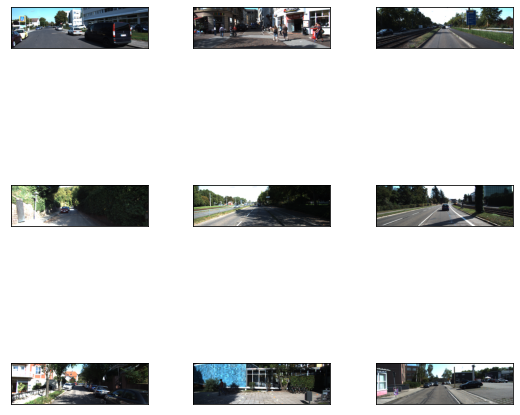

In [3]:
# 데이터셋 예시
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
# 데이터셋 정보 확인
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

- 6,347개의 training data, 711개의 test data, 423개의 validation data로 구성되어 있다.  
- 라벨에는 alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등의 정보가 있다.  
<span style='background-color: #fff5b1'>type</span> : Describes the type of object: 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc' or 'DontCare'  
<span style='background-color: #fff5b1'>truncated</span> : Float from 0 (non-truncated) to 1 (truncated), where truncated refers to the object leaving image boundaries  
<span style='background-color: #fff5b1'>occluded</span> : Integer (0,1,2,3) indicating occlusion state -> 0 = fully visible / 1 = partly occluded / 2 = largely occluded, 3 = unknown  
<span style='background-color: #fff5b1'>alpha</span> : Observation angle of object, ranging [-pi..pi]  
<span style='background-color: #fff5b1'>bbox</span> : 2D bounding box of object in the image (0-based index) -> contains left, top, right, bottom pixel coordinates  
<span style='background-color: #fff5b1'>dimensions</span> : 3D object dimensions -> height, width, length (in meters)  
<span style='background-color: #fff5b1'>location</span> : 3D object location x,y,z in camera coordinates (in meters)  
<span style='background-color: #fff5b1'>rotation_y</span> : Rotation ry around Y-axis in camera coordinates [-pi..pi]  
<span style='background-color: #fff5b1'>score</span> : Only for results: Float, indicating confidence in detection, needed for p/r curves, higher is better.  

## 6-3. 자율주행 보조장치 (2) 데이터 직접 확인하기

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-1.58,  2.08,  1.78, -1.51], dtype=float32)>, 'bbox': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.47138667, 0.47376007, 0.5426667 , 0.4955314 ],
       [0.26789334, 0.0534219 , 0.5182667 , 0.20785025],
       [0.45277333, 0.32633656, 0.54642665, 0.366562  ],
       [0.47277334, 0.43785828, 0.54112   , 0.45958132]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[1.65, 1.67, 3.64],
       [1.68, 1.67, 3.87],
       [1.87, 1.8 , 4.72],
       [1.61, 1.51, 4.5 ]], dtype=float32)>, 'location': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ -0.57,   1.59,  46.82],
       [ -9.09,   1.85,  14.99],
       [-10.22,   1.76,  41.23],
       [ -3.5 ,   1.6 ,  48.14]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 1, 0])>, 'rotation_y': <tf.Tensor: shape=(4,

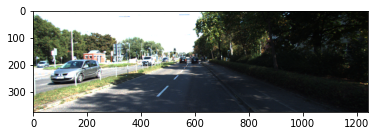

In [5]:
# 데이터셋을 하나씩 뽑은 후 정보 확인하기(image와 label 얻기)
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

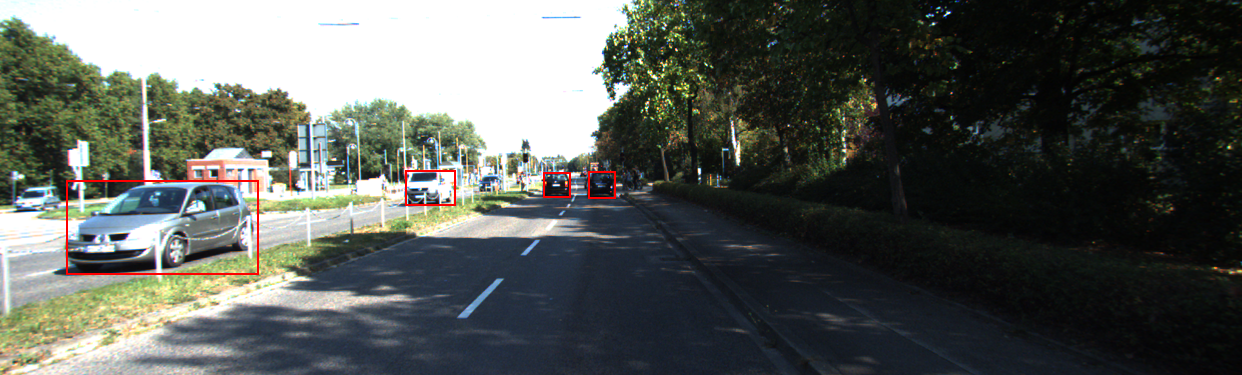

In [7]:
# 이미지 위에 바운딩 박스 그리기
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

- [ImageDraw 모듈(Pillow 라이브러리)](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html)

## 6-4. RetinaNet

### RetinaNet
- [Focal Loss for Dense Object Detection 논문](https://arxiv.org/pdf/1708.02002.pdf)을 통해 공개된 detection 모델   
- 1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 있어 이를 해결하기 위해 RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network)를 적용한 네트워크를 사용한다.

### Focal Loss
- [Focal Loss 참고 설명](https://visionhong.tistory.com/40)
![focal loss](https://user-images.githubusercontent.com/116326867/213750468-e2d87048-9d53-495a-8c7c-aac026f44fae.png)
- Focal loss는 기존의 1-stage detection 모델들(YOLO, SSD)이 물체 전경과 배경을 담고 있는 모든 그리드(grid)에 대해 한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하고자 도입되었다. 그림 왼쪽 7x7 feature level에서는 한 픽셀(pixel)이고, 오른쪽의 image level(자동차 사진)에서 보이는 그리드(grid)는 각 픽셀의 receptive field이다.
- 사용하는 이미지는 물체보다는 많은 배경을 학습하게 되는데, 논문에서는 이를 해결하기 위해서 Loss를 개선하여 정확도를 높였다.

![focal_loss](https://user-images.githubusercontent.com/116326867/213765269-fdca9e37-4c07-4a01-9c81-db78524f64c9.png)
- Focal loss는 교차 엔트로피를 기반으로 만들어졌다. 위 그림에서 식을 보면 Focal loss는 교차 엔트로피 CE(Pt)의 앞단에 간단히 (1-Pt)의 (감마)승 이라는 modulating factor를 붙여주었다.
- 교차 엔트로피의 개형을 보면 ground truth class에 대한 확률이 높으면 잘 분류된 것으로 판단되므로 손실이 줄어든다. 하지만 확률이 1에 매우 가깝지 않은 이상 상당히 큰 손실로 이어진다. 이 상황은 물체 검출 모델을 학습시키는 과정에서 문제가 될 수 있다. 대부분의 이미지에서는 물체보다 배경이 많아서 이미지는 극단적으로 배경의 class가 많은 class imbalanced data라고 할 수 있다. 이렇게 너무 많은 배경 class에 압도되지 않도록 modulating factor로 손실을 조절해준다. (감마)를 0으로 설정하면 modulating factor (1-Pt)의 (감마)승이 1이 되어 일반적인 교차 엔트로피가 되고 (감마)가 커질수록 modulating이 강하게 적용된다.

### FPN(Feature Pyramid Network)


![FPN](https://user-images.githubusercontent.com/116326867/213853101-d3366c5b-5236-4e9d-b9cb-af7cf1afae57.png)
- FPN은 특성을 피라미드처럼 쌓아서 사용하는 방식이다. CNN 백본 네트워크에서는 다양한 레이어의 결과값을 특성 맵(feature map)으로 사용할 수 있다. 이때 컨볼루션 연산은 커널을 통해 일정한 영역을 보고 몇 개의 숫자로 요약해 내기 때문에, 입력 이미지를 기준으로 생각하면 입력 이미지와 먼 모델의 뒷쪽의 특성 맵일수록 하나의 "셀(cell)"이 넓은 이미지 영역의 정보를 담고 있고, 입력 이미지와 가까운 앞쪽 레이어의 특성 맵일수록 좁은 범위의 정보를 담고 있다. 이를 receptive field라고 하며, 레이어가 깊어질 수록 pooling을 거쳐 넓은 범위의 정보(receptive field)를 갖게 된다.
- FPN은 백본의 여러 레이어를 한꺼번에 쓰겠다라는데에 의의가 있다. SSD가 각 레이어의 특성 맵에서 다양한 크기에 대한 결과를 얻는 방식을 취했다면 RetinaNet에서는 receptive field가 넓은 뒷쪽의 특성 맵을 upsampling(확대)하여 앞단의 특성 맵과 더해서 사용한다. 레이어가 깊어질수록 feature map의 w, h방향의 receptive field가 넓어지는데, 넓게 보는 것과 좁게 보는 것을 같이 쓴다는 의미이다.

![FPN구조](https://user-images.githubusercontent.com/116326867/213858974-2d48325d-bd89-42f4-ad6f-7aa76ed409c5.png)
- 위 그림은 통해 RetinaNet 논문에서 FPN 구조가 어떻게 적용되었는지 알 수 있다. RetinaNet에서는 FPN을 통해 P3부터 P7까지의 pyramid level을 생성해 사용하며, 각 pyramid level은 256개의 채널로 이루어지게 된다. 이를 통해 Classification Subnet과 Box Regression Subnet 2개의 Subnet을 구성하게 되는데, Anchor 개수를 A라고 하면 최종적으로 Classification Subnet은 K개 class에 대해 KA개 채널을, Box Regression Subnet은 4A개 채널을 사용하게 된다.

## 6-5. 데이터 준비
### 데이터 파이프 라인 : 학습에 맞는 형태로 데이터 바꿔주기
1. x와 y좌표 위치 교체
2. 무작위로 수평 뒤집기(Flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

In [8]:
# x와 y좌표 위치 교체
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [9]:
# 무작위로 수평 뒤집기(Flip)
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

In [10]:
# 이미지 크기 조정 및 패딩 추가
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

- 이미지 크기를 바꿀 때 이미지의 비율은 그대로 유지되어야 하고, 이미지의 최대/최소 크기도 제한해야 한다. 또 이미지의 크기를 바꾼 후에도 최종적으로 모델에 입력되는 이미지의 크기는 stride의 배수가 되도록 만들어야 한다. 예를 들어, 600x720 크기의 이미지가 있다면 800x960 크기로 바꿀 때, stride를 128로 놓아 800x960 크기의 이미지에 패딩을 더해 896x1024 크기의 이미지로 모델에 입력해야한다. (모델에 입력되는 이미지에는 검정 테두리가 생김)
- 실제로 입력할 이미지를 어떻게 바꿀지는 min_side, max_side, min_side_range, stride등에 의해 결정된다. 그리고 학습이 완료된 모델을 사용할 때는 입력할 이미지를 다양한 크기로 바꿀 필요는 없으니 분기처리를 해준다.

In [11]:
# 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [12]:
# 위의 함수들 연결하기
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

### 인코딩
- One stage detector에서는 Anchor Box라는 정해져 있는 위치, 크기, 비율 중에 하나로 물체의 위치가 결정된다. 그래서 기본적으로 물체 위치 후보라고 할 수 있는 Anchor Box를 생성해주어야 한다(물체 위치를 주관식이 아닌 객관식으로 풀도록 함). 예를 들어, 100개의 Anchor Box를 생성했다고 가정하면 이미 만들어진 100개의 Anchor Box에 해당하지 않는 위치, 크기, 비율에 물체가 있을 수 없다. 100개의 Anchor Box중 가장 근접한 하나가 선택이 되고, 그  Anchor Box를 기초로 정확한 위치를 찾아낸다. 추가로 Anchor Box로부터 상하좌우로 떨어진 정도, 가로 세로의 크기 차이를 미세하게 찾아내며, Anchor Box가 촘촘하게 겹치도록 생성되기 때문에 물체를 잘 찾아낼 수 있다.
- RetinaNet에서는 FPN을 사용하기 때문에 Anchor Box가 더 많이 필요하다. FPN의 각 층마다 Anchor Box가 필요하기 때문이다. RetinaNet의 FPN에서 pyramid level은 개수가 미리 약속되어 있기 때문에 각 level에서 만들어지는 Anchor Box도 약속되어 있다.

![anchor_box](https://user-images.githubusercontent.com/116326867/213860818-76f120d8-8613-4d82-82d4-d5c52ddbb05d.png)

In [13]:
# 논문의 AnchorBox 구현하기
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [14]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

# IoU를 계산할 수 있는 함수
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

- IoU를 계산할 수 있는 함수를 만드는 이유 : Anchor Box를 생성했으니 입력할 데이터를 Anchor Box에 맞게 변형해주어야 한다. 데이터 원본의 bbox는 주관식 정답이라고 볼 때, 모델은 객관식으로 문제를 풀어야 하기 때문에 주관식 정답을 가장 가까운 객관식 정답으로 바꿔줘야 모델을 학습시킬 수 있습니다. IoU가 높은지 낮은지에 따라 Anchor Box가 정답인지 오답인지 체크하는 방법을 통해 IoU를 사용하여 주관식 정답을 객관식 정답으로 바꿀 수 있다.

In [15]:
# 실제 라벨을 Anchor Box에 맞춰주는 클래스
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

- compute_iou 함수를 이용해서 IoU를 구하고 그 IoU를 기준으로 물체에 해당하는 Anchor Box와 배경이 되는 Anchor Box를 지정해준다. 그리고 그 Anchor Box와 실제 Bounding Box의 미세한 차이를 계산한다. 상하좌우의 차이, 가로세로 크기의 차이를 기록해 두는데 가로세로 크기는 로그를 사용해서 기록해둔다.
- 이 과정에서 variance가 등장하는데 관례적으로 Anchor Box를 사용할 때 등장한다. 정확한 이유가 등장하지는 않지만 상하좌우의 차이에는 0.1, 가로세로 크기의 차이에는 0.2를 사용한다. 통계적 추정치를 계산할 때 분산으로 나눠주는 것 때문이라는 의견이 있다.
![IoU](https://user-images.githubusercontent.com/116326867/213861473-3cc2e460-f877-4fad-a65e-38532242f9c0.png)
- IoU가 0.5보다 높으면 물체, 0.4보다 낮으면 배경으로 판단한다.

## 6-6. 모델 작성
### Feature Pyramid

In [16]:
# FPN
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

![FPN](https://user-images.githubusercontent.com/116326867/213861688-c7741faf-c0af-4fbd-af41-e7bda57a9982.png)
- RetinaNet에서는 FPN(Feature Pyramid Network)를 사용한다. (완전히 동일한 것은 아니고 약간 수정해서 사용)

In [17]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

- Object Detection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분이 필요한데, 그것을 head라고 부르기도 한다. Backbone에 해당하는 네트워크와 FPN을 통해 pyramid layer가 추출되고 나면 그 feature들을 바탕으로 class를 예상하고, box도 예상한다. class와 box가 모두 맞을 수도, class와 box 중 하나만 맞을 수도, 둘 다 틀릴 수도 있는데, class를 예측하는 head와 box를 예측하는 head가 별도로 존재한다는 점이 중요하다. 그래서 각각의 head를 만들어 주어야 하는데, head부분은 유사한 형태로 만들 수 있으니 build_head라는 함수를 하나만 만들고 두 번 호출할 것이다.

In [18]:
# RetinaNet의 backbone(ResNet50)
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

- RetinaNet의 backbone(ResNet50) : FPN에 이용할 수 있도록 중간 레이어도 output으로 연결해준다.

In [19]:
# RetinaNet
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

- RetinaNet : Backbone + FPN + classification용 head + box용 head

In [20]:
# Box Regression -> Smooth L1 Loss
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


# Classification Loss -> Focal Loss
class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


# RetinaNet Loss
class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

![loss](https://user-images.githubusercontent.com/116326867/213862372-1b404e0a-a04c-4fea-b039-7e2f2b4fd1fb.png)
- RetinaNet에서는 Focal Loss를 사용한다. Box Regression에는 사용하지 않고 Classification Loss를 계산하는데만 사용되고, Box Regression에는 Smooth L1 Loss를 사용한다.
- Smooth L1 Loss을 사용하는 Box Regression에는 delta를 기준으로 계산이 달라지고, Focal Loss를 사용하는 Classification에서는 alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라지는 점에 주의할 것.

## 6-7. 모델 학습

In [21]:
# 앞에서 만든 클래스와 함수를 이용해서 모델 조립하기
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

94781440/94765736 [==============================] - 0s 0us/step


In [22]:
# learning rate과 optimizer
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

- Learning Rate에 있어서 논문에서는 8개의 GPU를 사용하여 환경이 다른 상황이므로 Learning Rate를 적절히 바꿔준다. Optimizer는 논문과 동일하게 적용한다.

In [23]:
# 데이터 전처리를 위한 파이프라인 만들기
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

In [26]:
# 학습하기 -> 학습시간이 오래 걸리므로 미리 학습하여 저장되어 있는 파일 이용
#model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
#callbacks_list = [
#    tf.keras.callbacks.ModelCheckpoint(
#        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
#        monitor="loss",
#        save_best_only=False,
#        save_weights_only=True,
#        verbose=1,
#    )
#]

#epochs = 1

#model.fit(
#    train_dataset,
#    validation_data=val_dataset,
#    epochs=epochs,
#    callbacks=callbacks_list
#)

## 6-8. 결과 확인하기

In [27]:
# 학습된 모델 불러오기
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

In [28]:
# 모델의 추론 결과를 처리할 함수를 레이어 형식으로 만들기
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

![DecodePredictions](https://user-images.githubusercontent.com/116326867/213862960-33254147-f606-499c-bce1-dff448c4d9cb.png)
- 모델의 추론 결과를 처리할 함수를 레이어 형식으로 만들어 주는데, 논문에서는 1000개의 후보를 골라 처리했지만 100개의 후보만 골라 처리하도록 하고, 나머지 설정은 논문과 동일하게 한다.
- NMS(Non-Max Suppression)는 직접 구현하지 않고 주어진 tf.image.combined_non_max_suppression를 사용했다.
- [참고 자료](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression) : 입출력되는 값 파악하기. 특히 출력에 nmsed_boxes, nmsed_scores, nmsed_classes, valid_detections이 각각 무엇인지 알아야 활용할 수 있다.

In [29]:
# 추론이 가능한 모델 조립하기
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [30]:
# 모델의 추론 결과 시각화 함수
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [31]:
# 추론시에 입력 데이터를 전처리하기 위한 함수
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

- 학습을 위한 전처리와 추론을 위한 전처리가 다르기 때문에 따로 작성해야 한다.

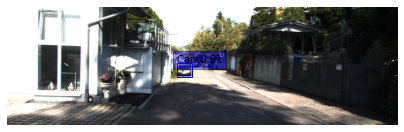

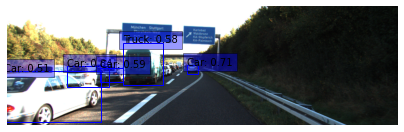

In [32]:
# 결과 확인
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )